In [1]:
#### 2.Methylation_data_analysis.R
# It's from TCGA PanCancerAtlas_Publish series paper data
# https://gdc.cancer.gov/about-data/publications/pancanatlas
### 1) Loading DNA methylation mergedMethyl_27K_450K_dataset
COAD_PanCancerAtlas_Publish_mergedMethyl_27K_450K_dataset <- readRDS("/data8t_4/JH/MyJobs/Read_dataset/TCGA_PanCancerAtlas_Publications/DNA_Methylation_Merged_27K_450K_Only/COAD_PanCancerAtlas_Publish_mergedMethyl_27K_450K_dataset.rds")
COAD.mergedMethyl.27.450.mx <- COAD_PanCancerAtlas_Publish_mergedMethyl_27K_450K_dataset$COAD.mergedMethyl.27.450.mx
COAD_PanCancerAtlas_Publish_mergedMethyl_27K_450K_dataset$metadata #
### 2)Read cluster resaults
Cluster.20200201.V7.Tumor <- readRDS("/data8t_4/JH/MyJobs/NormalCancer_TCGA_V2/Cluster.20200201.V7.Tumor.rds")
cutree.res <- Cluster.20200201.V7.Tumor$cutree.res
dynamicColors <- Cluster.20200201.V7.Tumor$dynamicColors
Cluster.df <- cbind(cutree.res,dynamicColors) 
Cluster.df <- as.data.frame(Cluster.df)
Cluster.df$rownames <- rownames(Cluster.df)
hclust.Res <- Cluster.20200201.V7.Tumor$hclust.Res


$http
[1] "https://gdc.cancer.gov/about-data/publications/pancanatlas"

$paper
[1] "Integrated TCGA Pan-Cancer Clinical Data Resource to Drive High-Quality Survival Outcome Analytics"

[1] 21418   522

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which.min

Welcome to Bioconductor

    

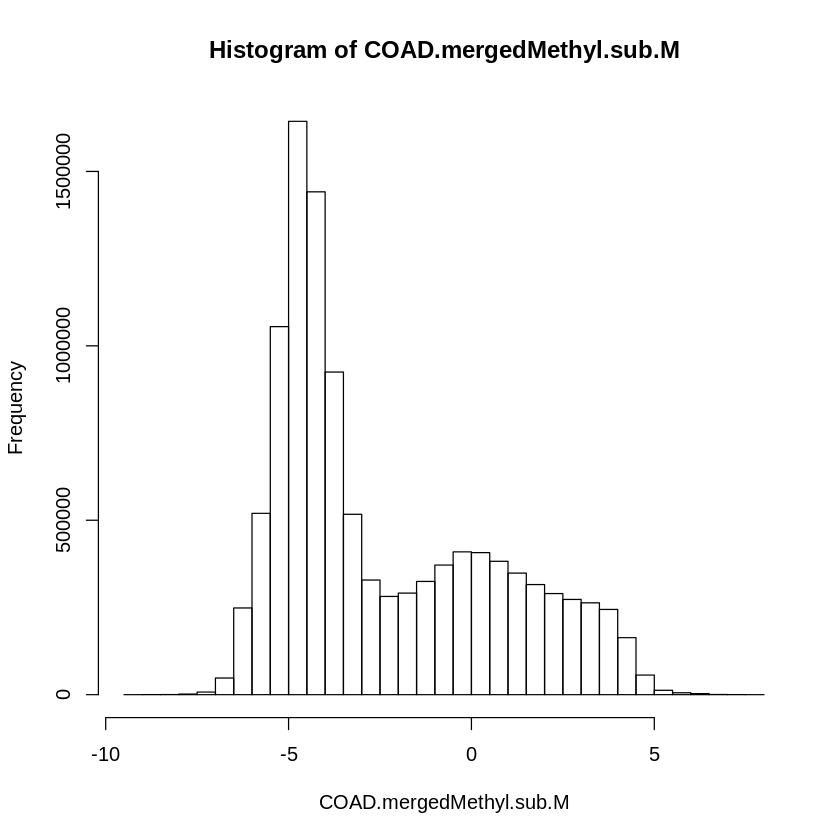

,TCGA.3L.AA1B.01,TCGA.4N.A93T.01,TCGA.4T.AA8H.01,TCGA.5M.AAT4.01,TCGA.5M.AAT6.01
cg00000292,0.5007367,1.154466,1.399276,1.995066,1.0928787
cg00003994,-4.2559397,-3.206756,-4.233533,-3.826989,-4.3751828
cg00005847,1.1401940,2.933274,2.755836,2.675578,-0.2146937
cg00007981,-5.3057116,-5.464714,-5.436194,-5.608425,-5.5494079
cg00008493,3.7958650,3.864289,4.018610,4.153974,3.2782383



FALSE  TRUE 
    8   278 

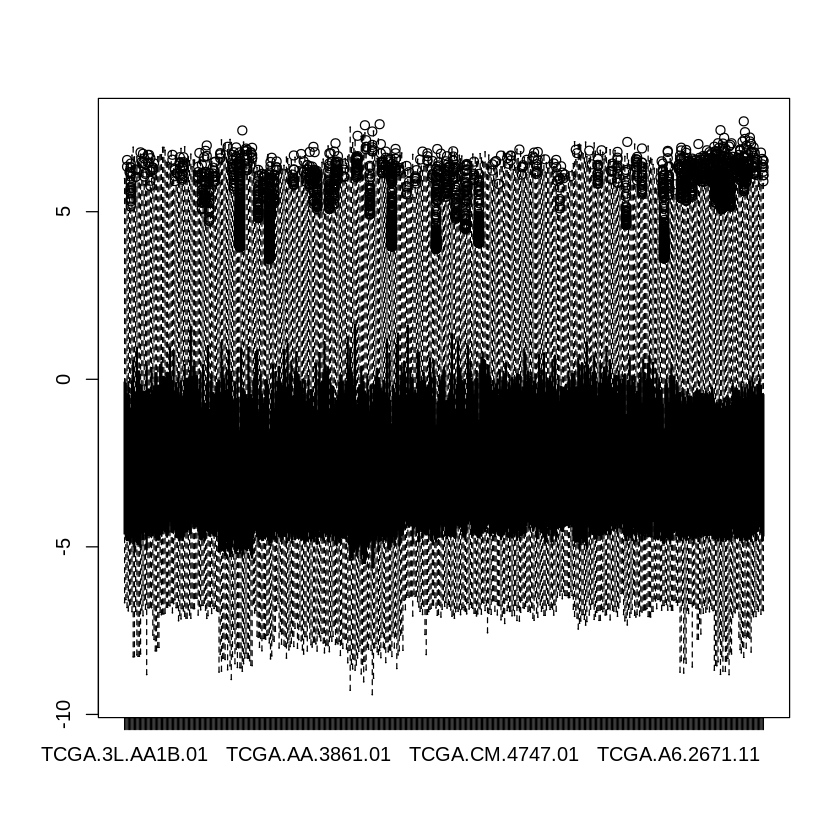

In [2]:
## 3) remove rows contain NAs
COAD.mergedMethyl.sub <- COAD.mergedMethyl.27.450.mx[complete.cases(COAD.mergedMethyl.27.450.mx), ]
dim(COAD.mergedMethyl.sub)
## 4) Convert methylation Beta-value to M-value
library(lumi)
COAD.mergedMethyl.sub.M <- beta2m(COAD.mergedMethyl.sub)
hist(COAD.mergedMethyl.sub.M)
boxplot(COAD.mergedMethyl.sub.M)
#class(COAD.mergedMethyl.sub.M)
COAD.mergedMethyl.sub.M[1:5,1:5]
#dim(COAD.mergedMethyl.sub.M)
## 5)Builed ExpressionSet
library(Biobase)
table(Cluster.df$rownames %in% colnames(COAD.mergedMethyl.sub.M))
sampleID <- Cluster.df$rownames[Cluster.df$rownames %in% colnames(COAD.mergedMethyl.sub.M)]
Cluster.df.sub <- new("AnnotatedDataFrame",
                      data=Cluster.df[sampleID,])
COAD.methy.set <- ExpressionSet(assayData=COAD.mergedMethyl.sub.M[,sampleID],
                                phenoData=Cluster.df.sub)



Attaching package: ‘limma’

The following object is masked from ‘package:BiocGenerics’:

    plotMA



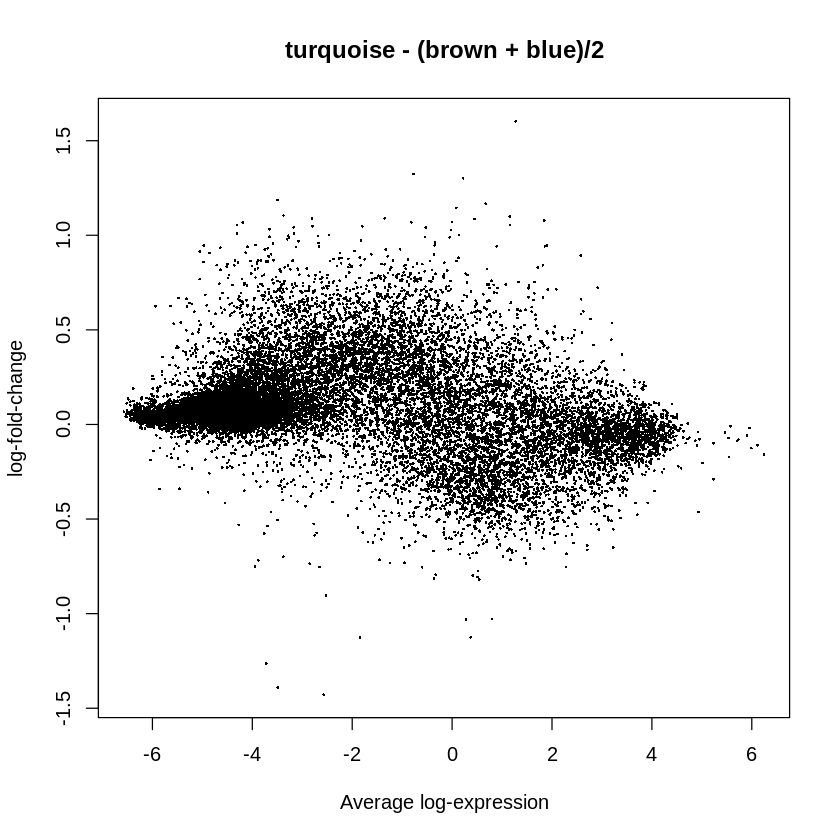

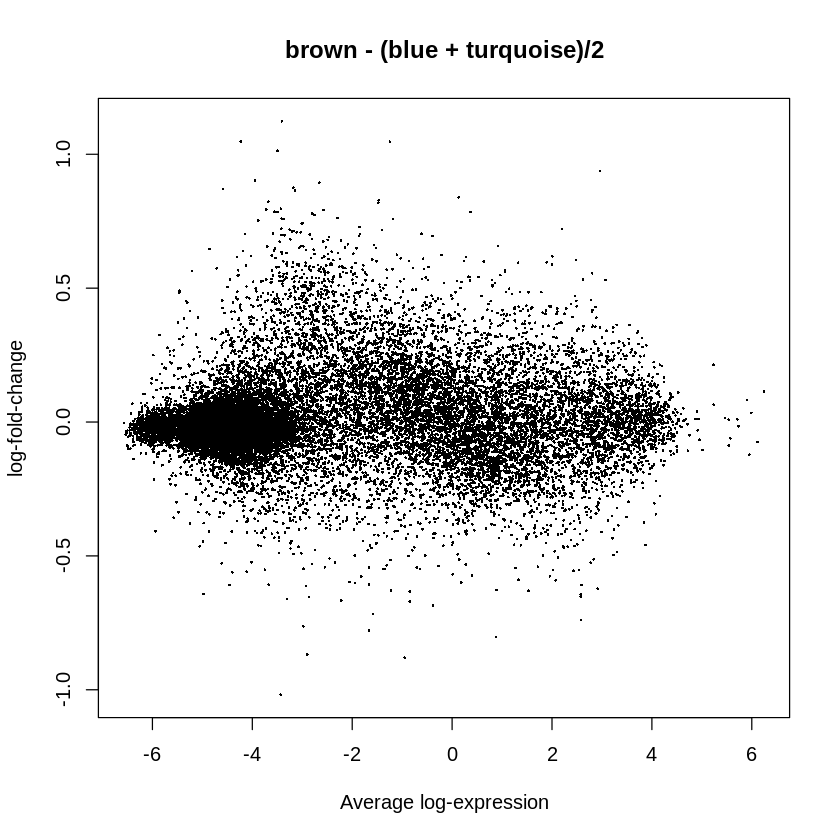

       blue - (brown + turquoise)/2 brown - (blue + turquoise)/2
Down                           3855                           17
NotSig                        16307                        21301
Up                             1256                          100
       turquoise - (brown + blue)/2
Down                           1060
NotSig                        16005
Up                             4353

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
cg01965939,-0.7449214,-2.693509,-10.276692,3.441993e-21,5.178110e-17,37.40769
cg19258882,-0.7655777,-1.840883,-10.231343,4.835288e-21,5.178110e-17,37.07618
cg17740645,-0.8589368,-2.377089,-10.172166,7.526944e-21,5.373737e-17,36.64456
cg17186163,-0.6200475,-2.223887,-10.044616,1.946314e-20,1.042154e-16,35.71806
cg15376097,-0.8148304,-2.778983,-9.933187,4.443804e-20,1.903548e-16,34.91302
cg10917602,-0.7897167,-1.331515,-9.903903,5.516702e-20,1.969279e-16,34.70214


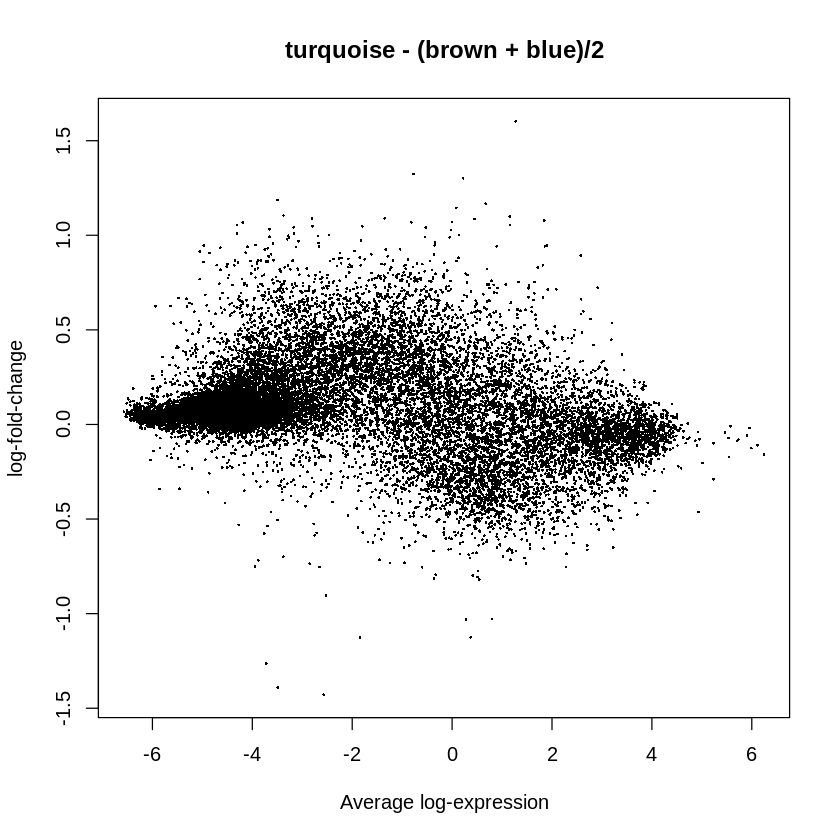

In [3]:
## 6) Probe-wise differential methylation analysis
#https://www.bioconductor.org/packages/devel/workflows/vignettes/methylationArrayAnalysis/inst/doc/methylationArrayAnalysis.html
## Several Groups experiment design
library(limma)
#Cluster.df.sub@data$dynamicColors
f.meth <- factor(Cluster.df.sub@data$dynamicColors, levels=c("blue","brown","turquoise","yellow"))
design.meth <- model.matrix(~0+f.meth)
colnames(design.meth) <- c("blue","brown","turquoise","yellow")
## 7) limma DE gene contrast building
fit.meth <- lmFit(COAD.methy.set, design.meth)
contrast.matrix.methy <- makeContrasts(blue-(brown+turquoise)/2, 
                                       brown-(blue+turquoise)/2,
                                       turquoise-(brown+blue)/2,
                                       levels=design.meth)
# fit the contrasts
fit.meth.2 <- contrasts.fit(fit.meth, contrast.matrix.methy)
fit.meth.2 <- eBayes(fit.meth.2)
plotMD(fit.meth.2)
plotMD(fit.meth.2, column = 2)
plotMD(fit.meth.2, column = 3)
## 8) Set up cutoff for top DE genes
adjPvalueCutoff <- 0.01
logFCcutoff <- 0.5
summary(decideTests(fit.meth.2))
number = 100
DMPs.blue <- topTable(fit.meth.2, num=number, coef="blue - (brown + turquoise)/2")
DMPs.brown <- topTable(fit.meth.2, num=number, coef="brown - (blue + turquoise)/2")
DMPs.turquoise <- topTable(fit.meth.2, num=number, coef="turquoise - (brown + blue)/2")
head(DMPs.blue)

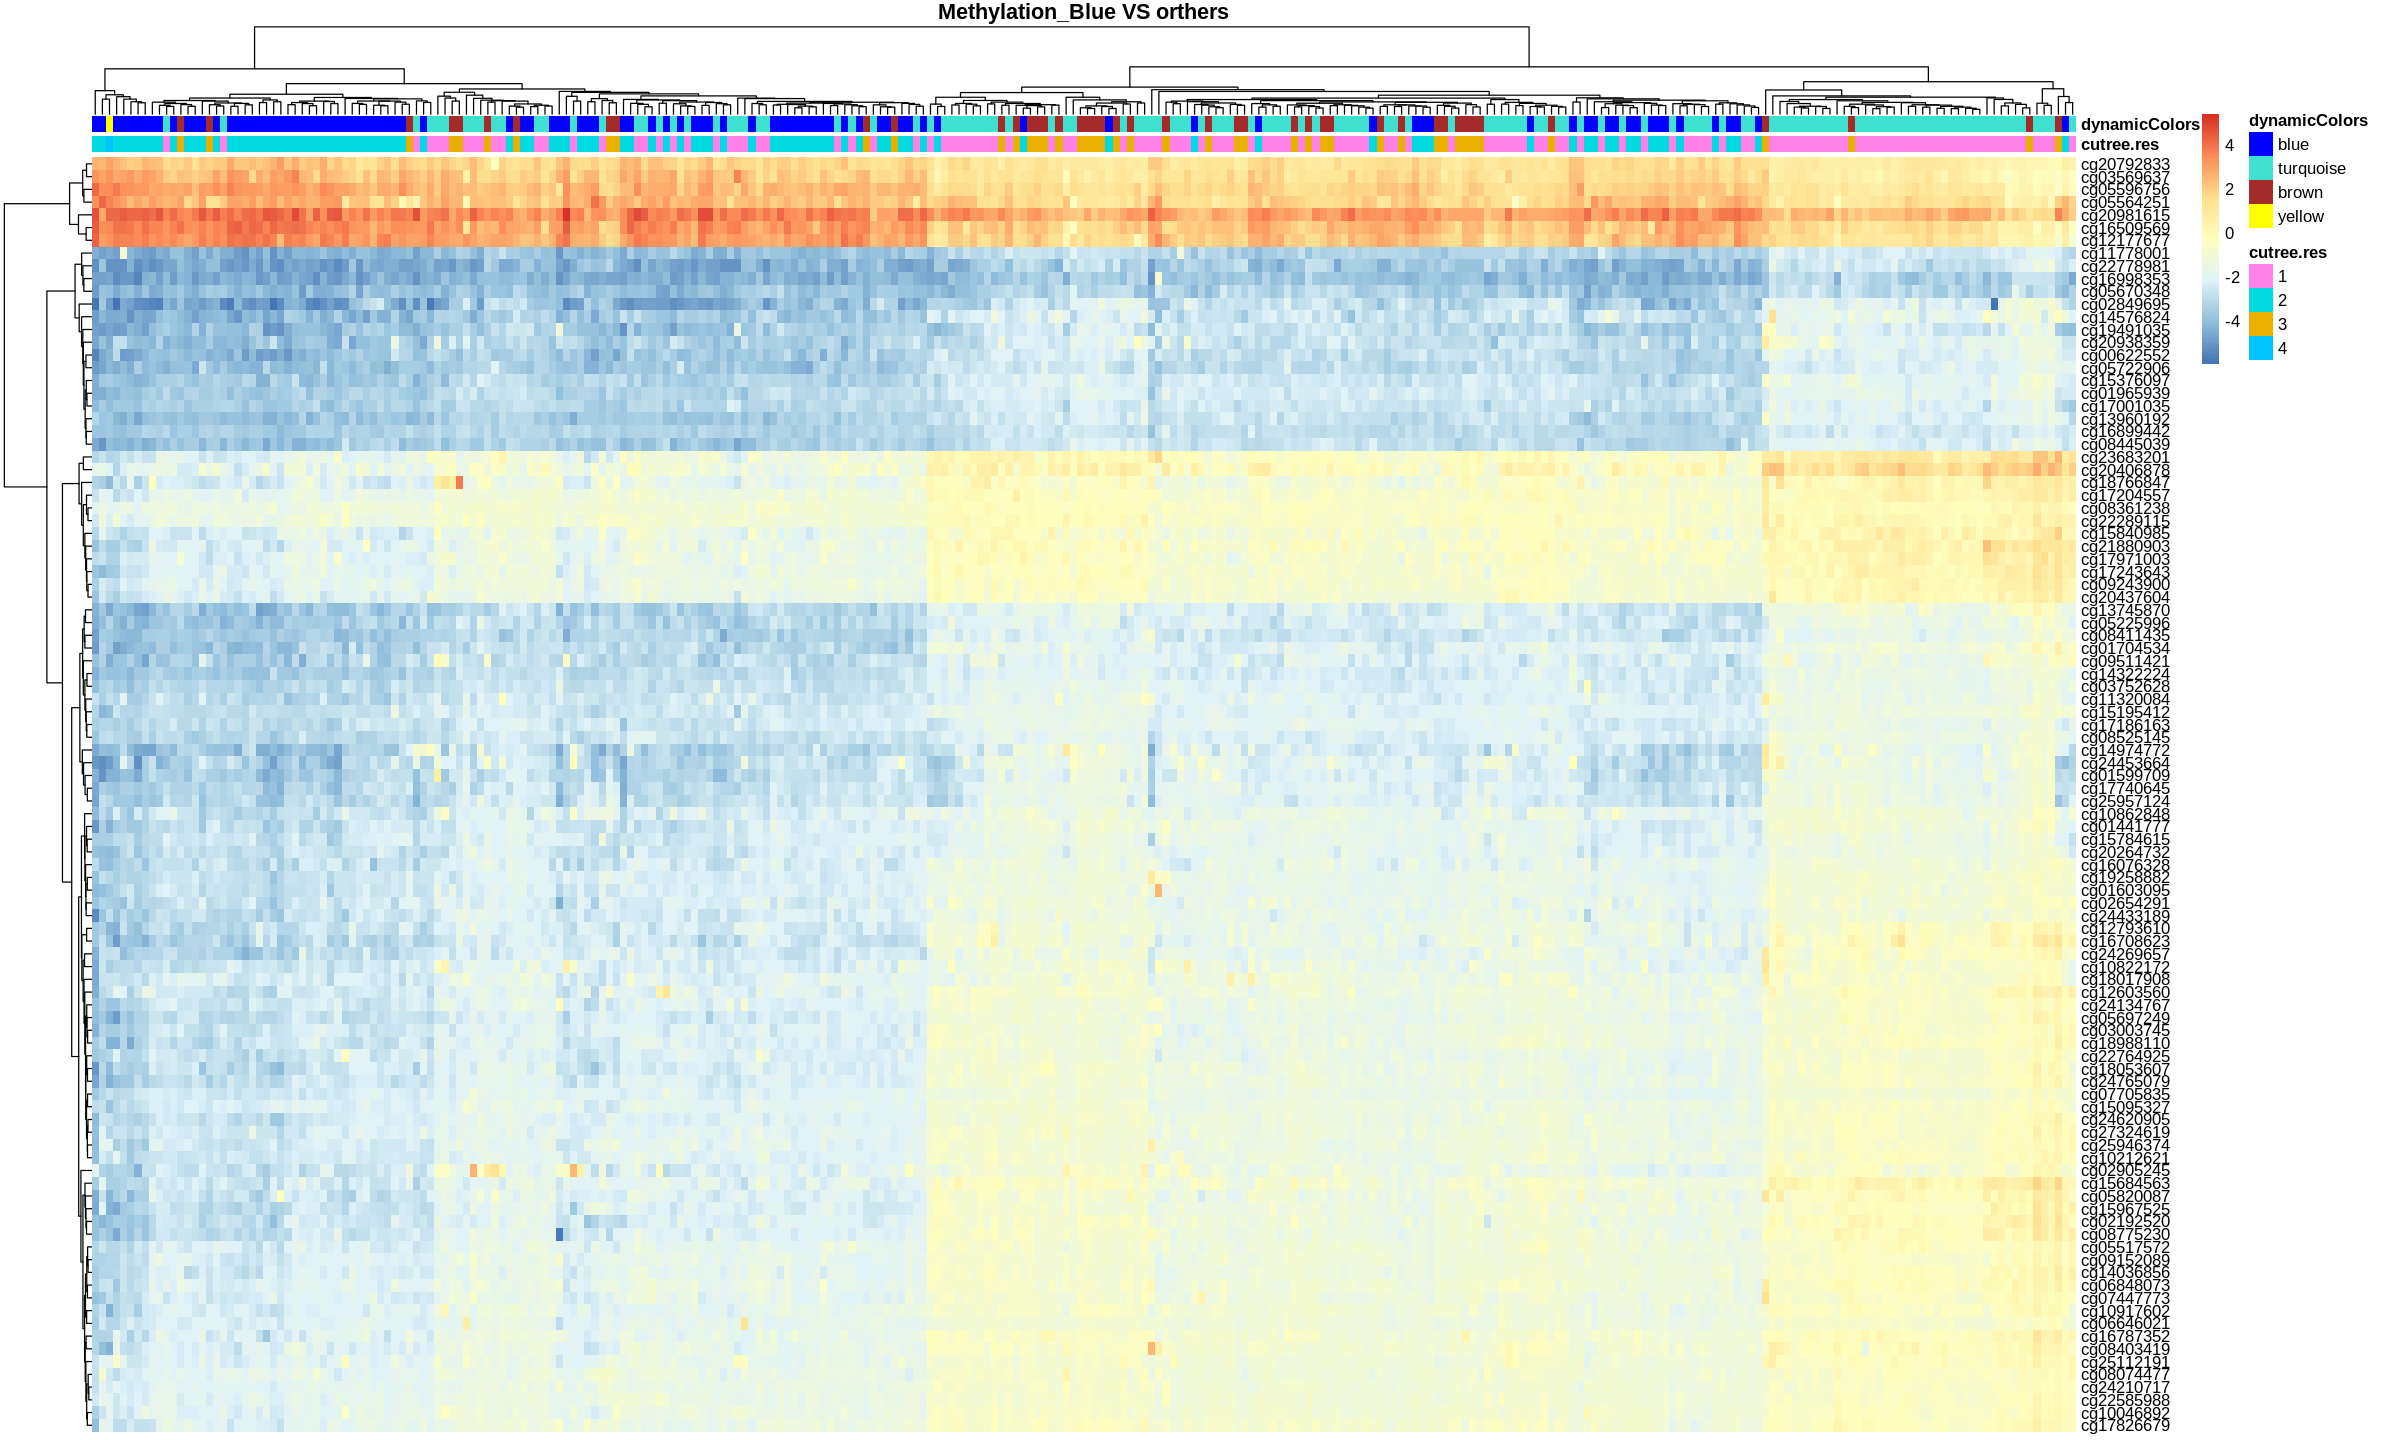

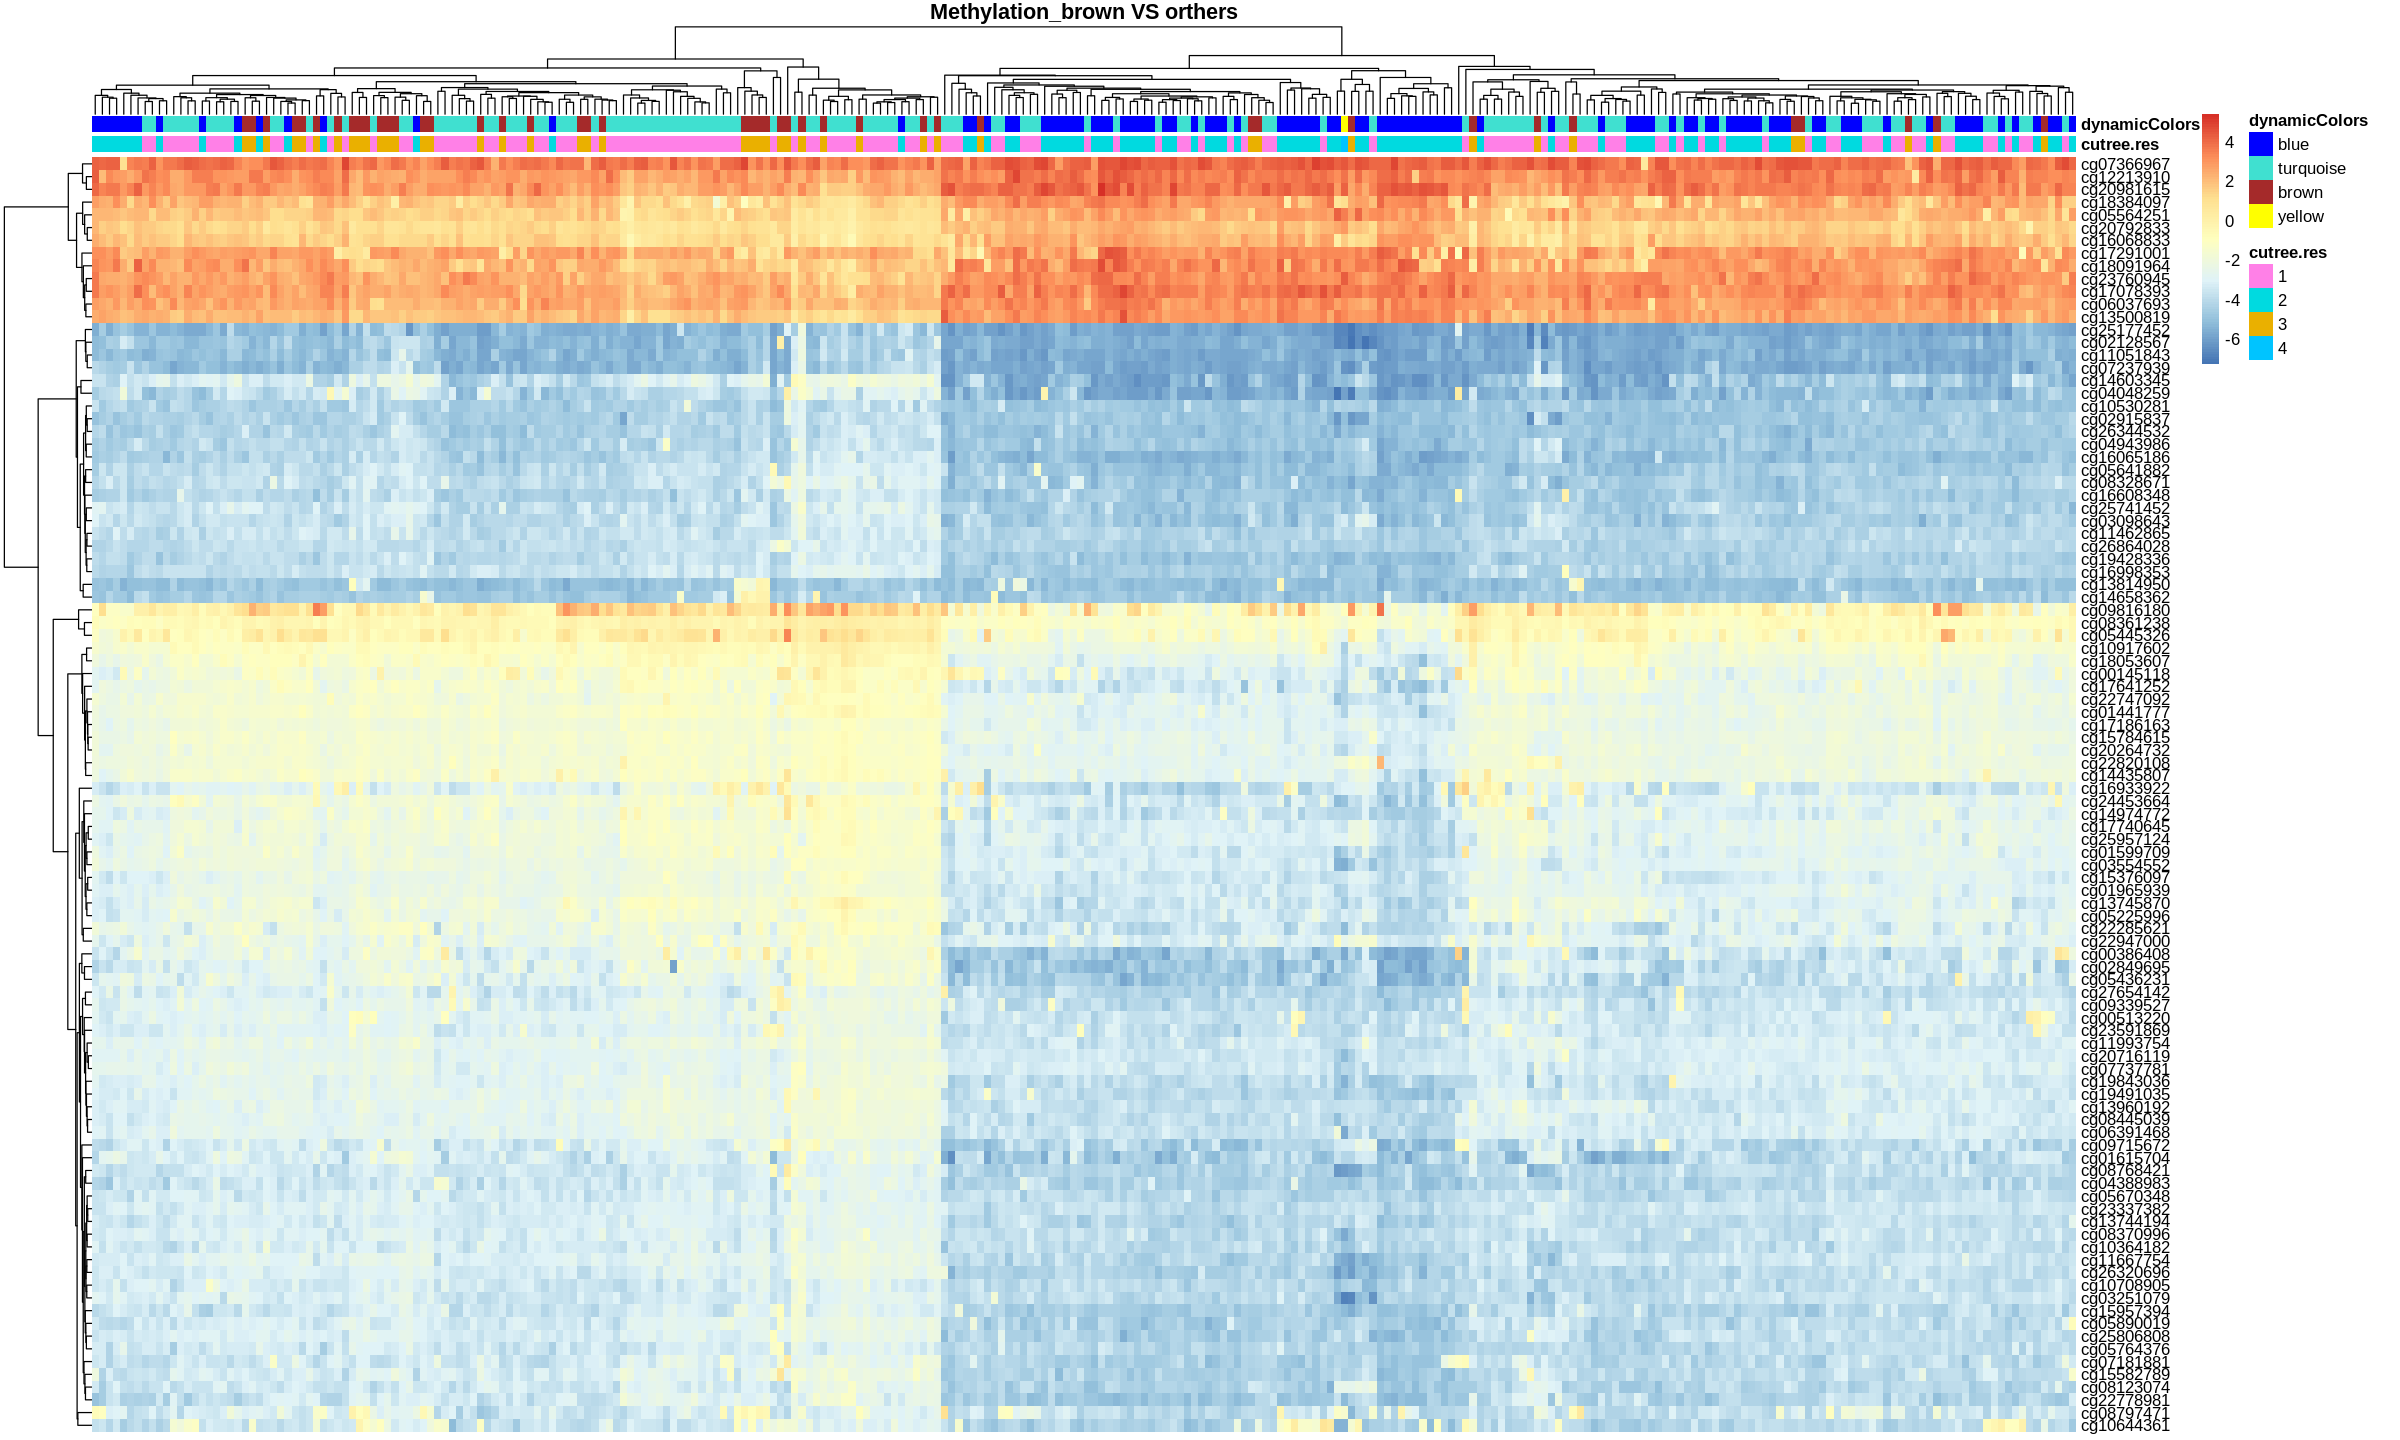

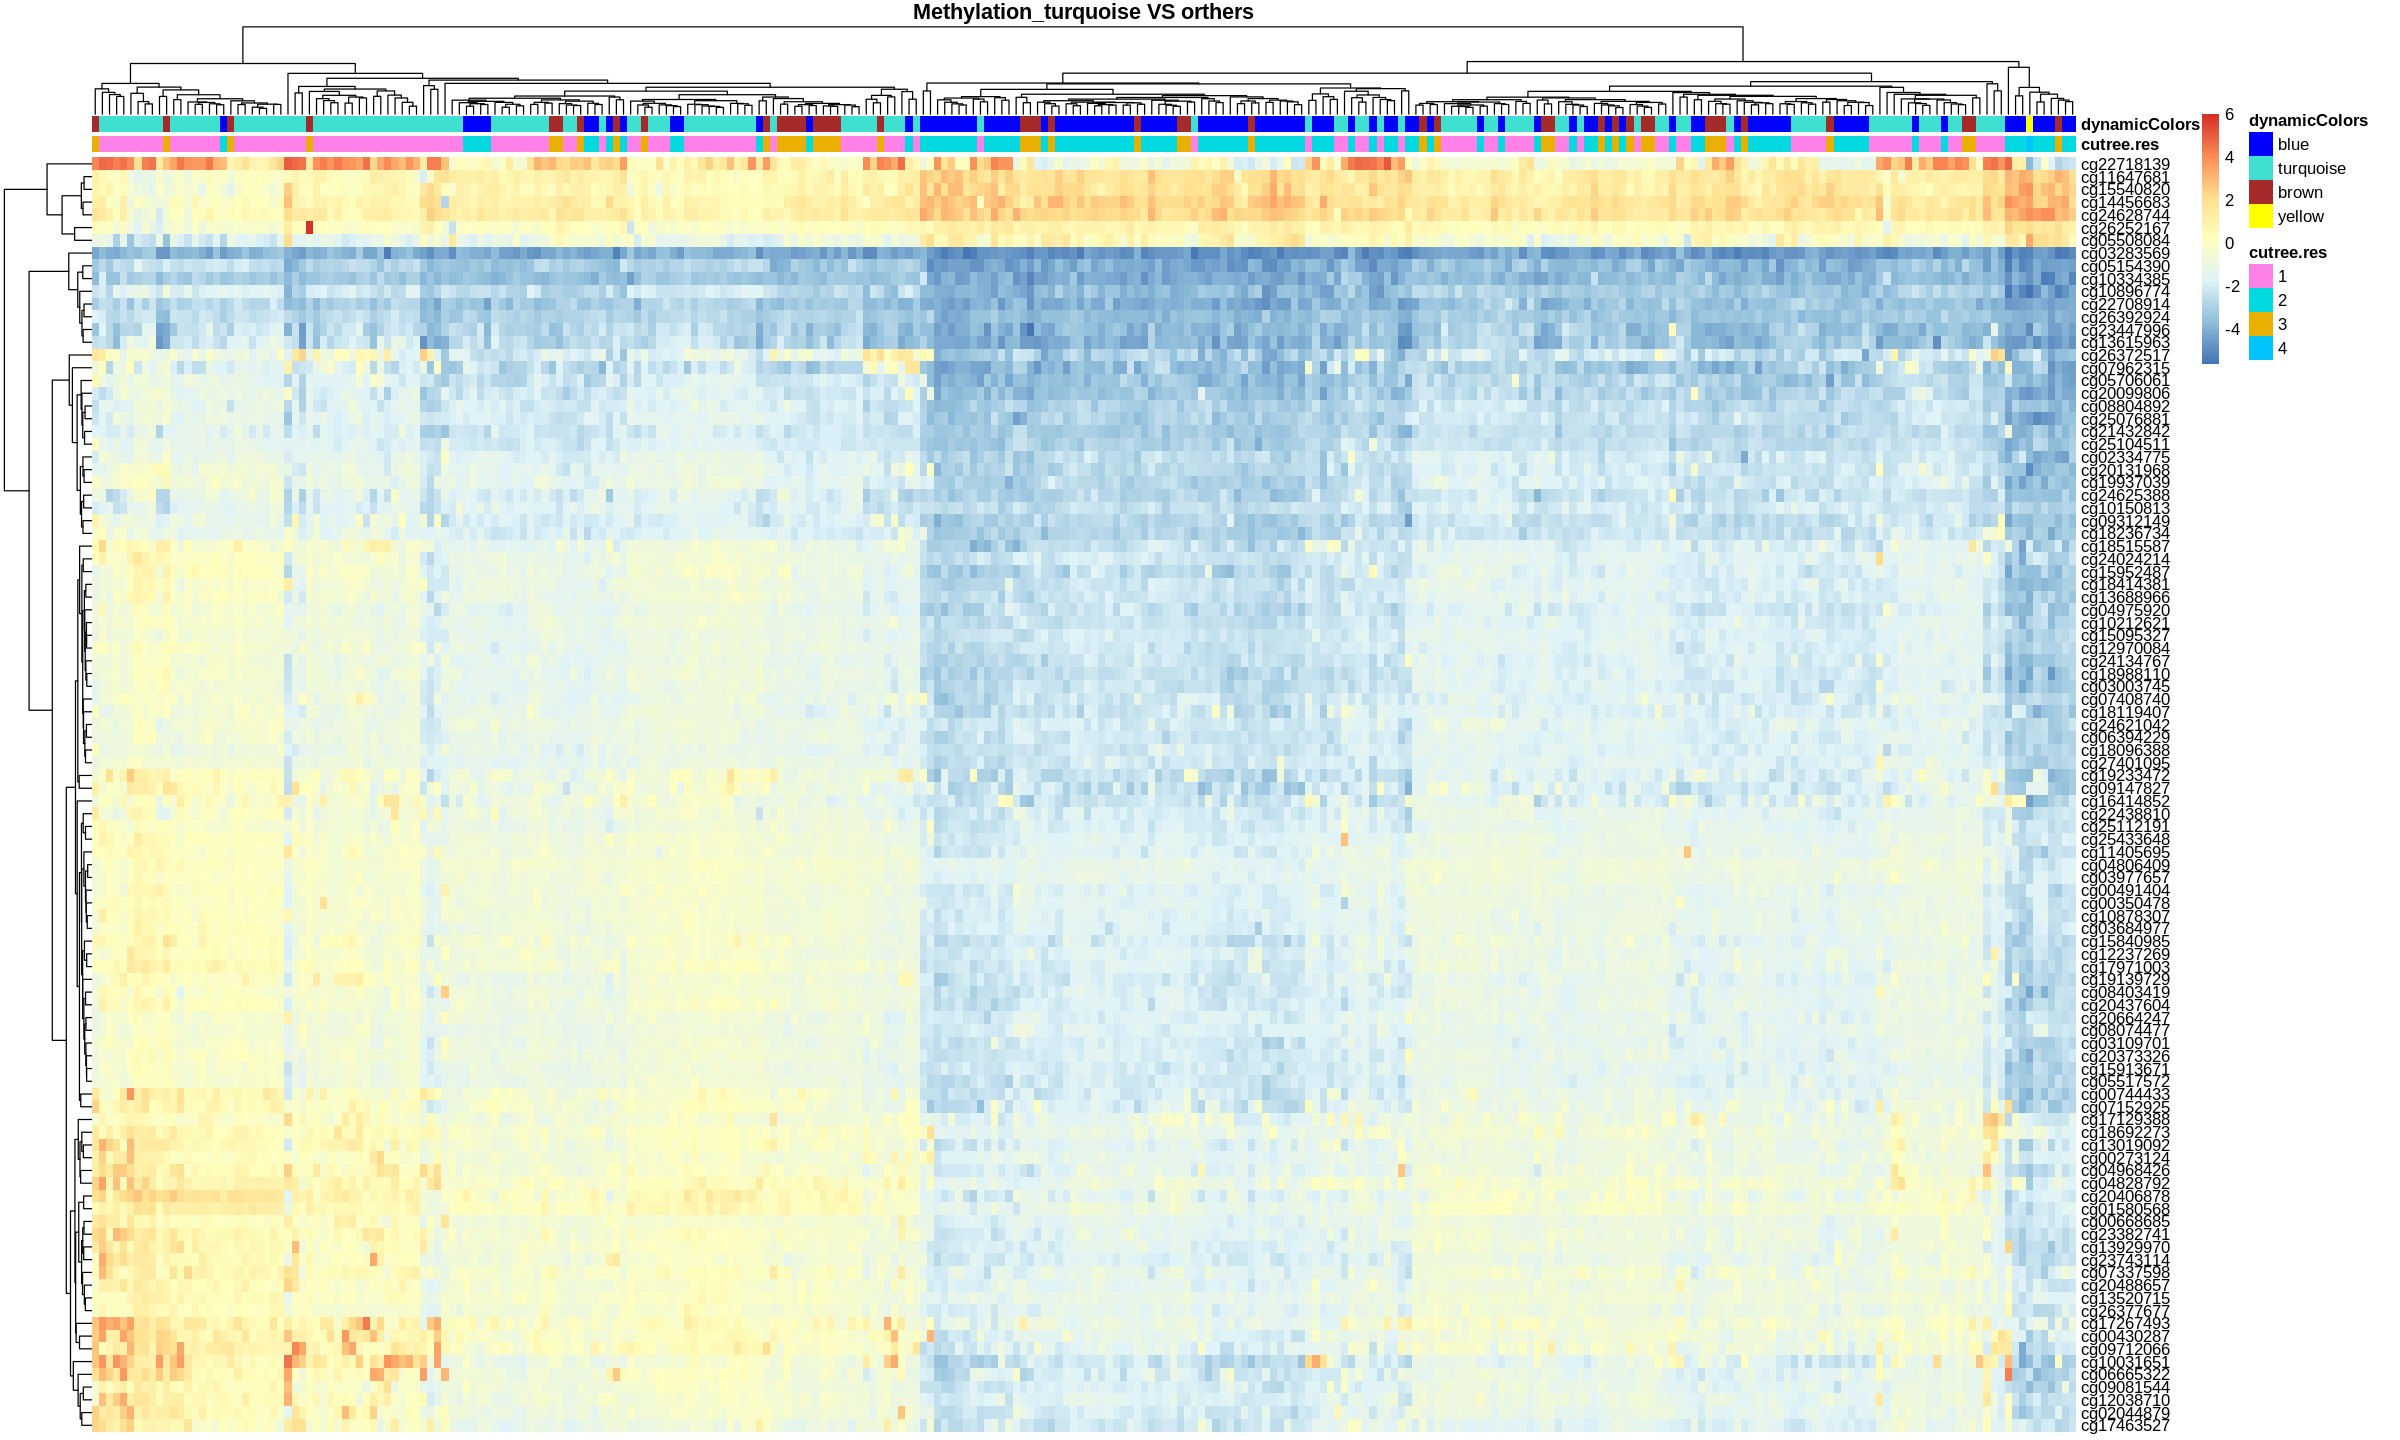

In [4]:
## 9) Heatmap ploting
options(repr.plot.width=20, repr.plot.height=12)
ann_colors = list(dynamicColors = c(blue = "blue",turquoise = "turquoise", 
                                    brown = "brown", yellow = "yellow"))
pheatmap::pheatmap(COAD.methy.set[rownames(DMPs.blue),],annotation_col = pData(COAD.methy.set)[,1:2], show_colnames = F,
                   main = "Methylation_Blue VS orthers",annotation_colors = ann_colors)
pheatmap::pheatmap(COAD.methy.set[rownames(DMPs.brown),],annotation_col = pData(COAD.methy.set)[,1:2],show_colnames = F,
                   main = "Methylation_brown VS orthers",annotation_colors = ann_colors)
pheatmap::pheatmap(COAD.methy.set[rownames(DMPs.turquoise),],annotation_col = pData(COAD.methy.set)[,1:2],show_colnames = F,
                   main = "Methylation_turquoise VS orthers",annotation_colors = ann_colors)



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -2.000   1.257   1.436   1.413   1.588   2.000 

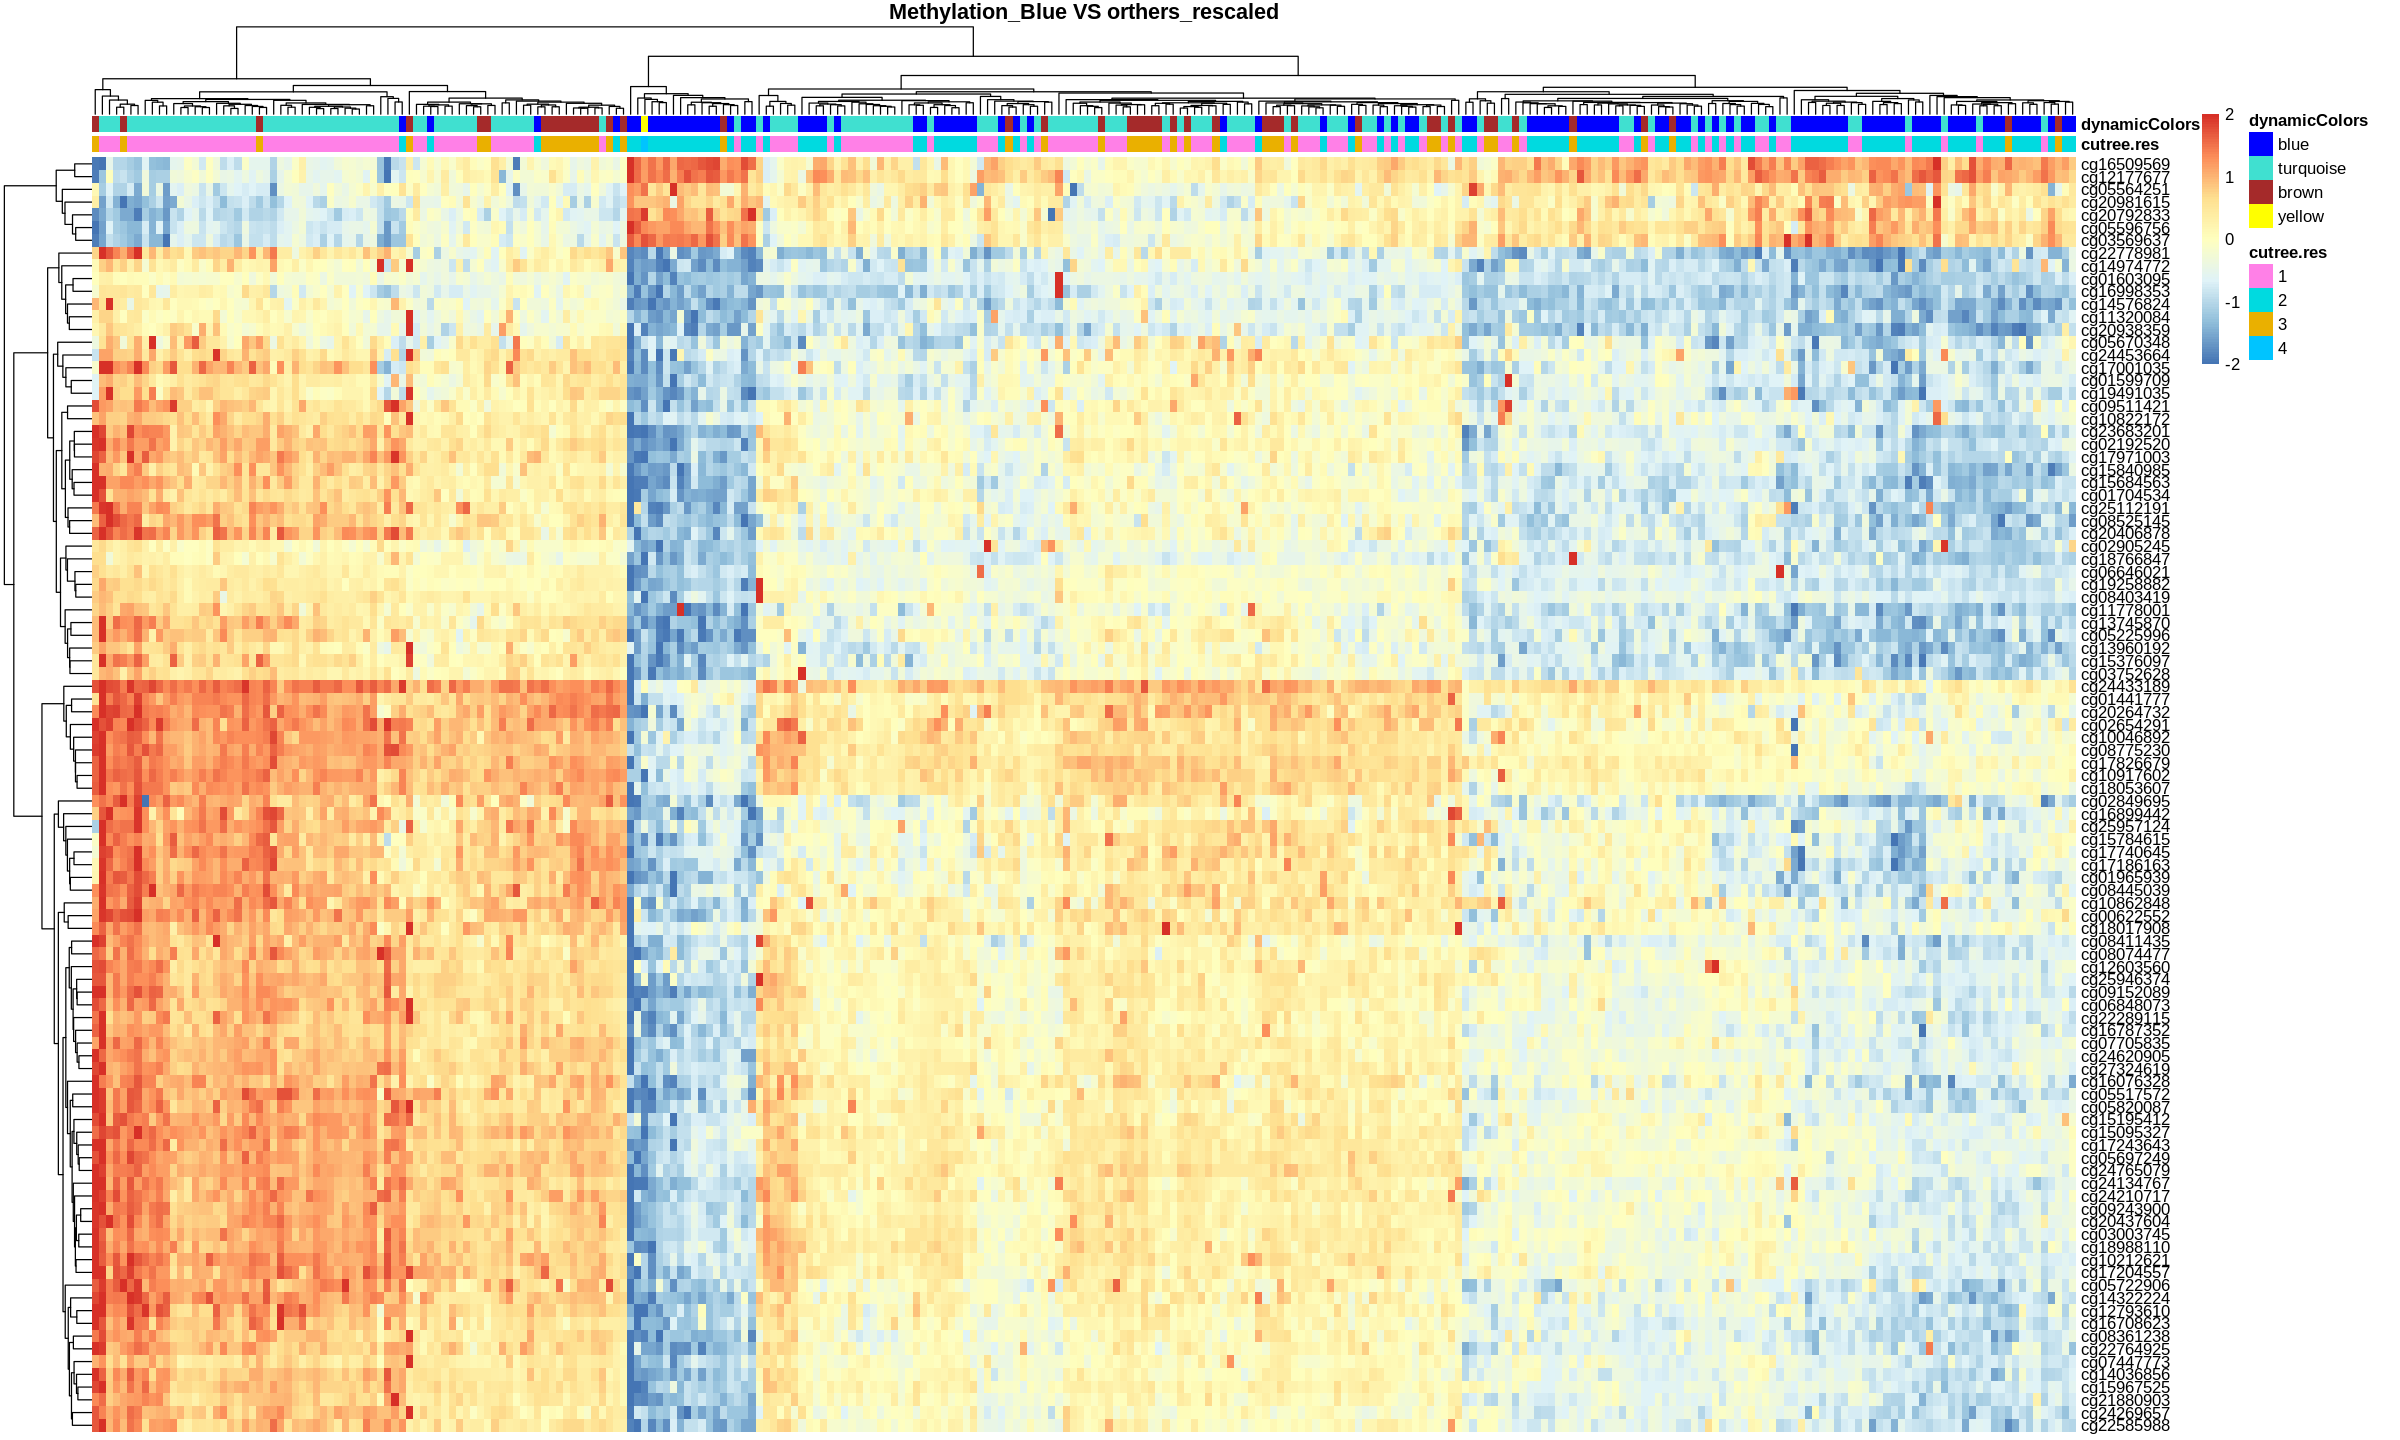

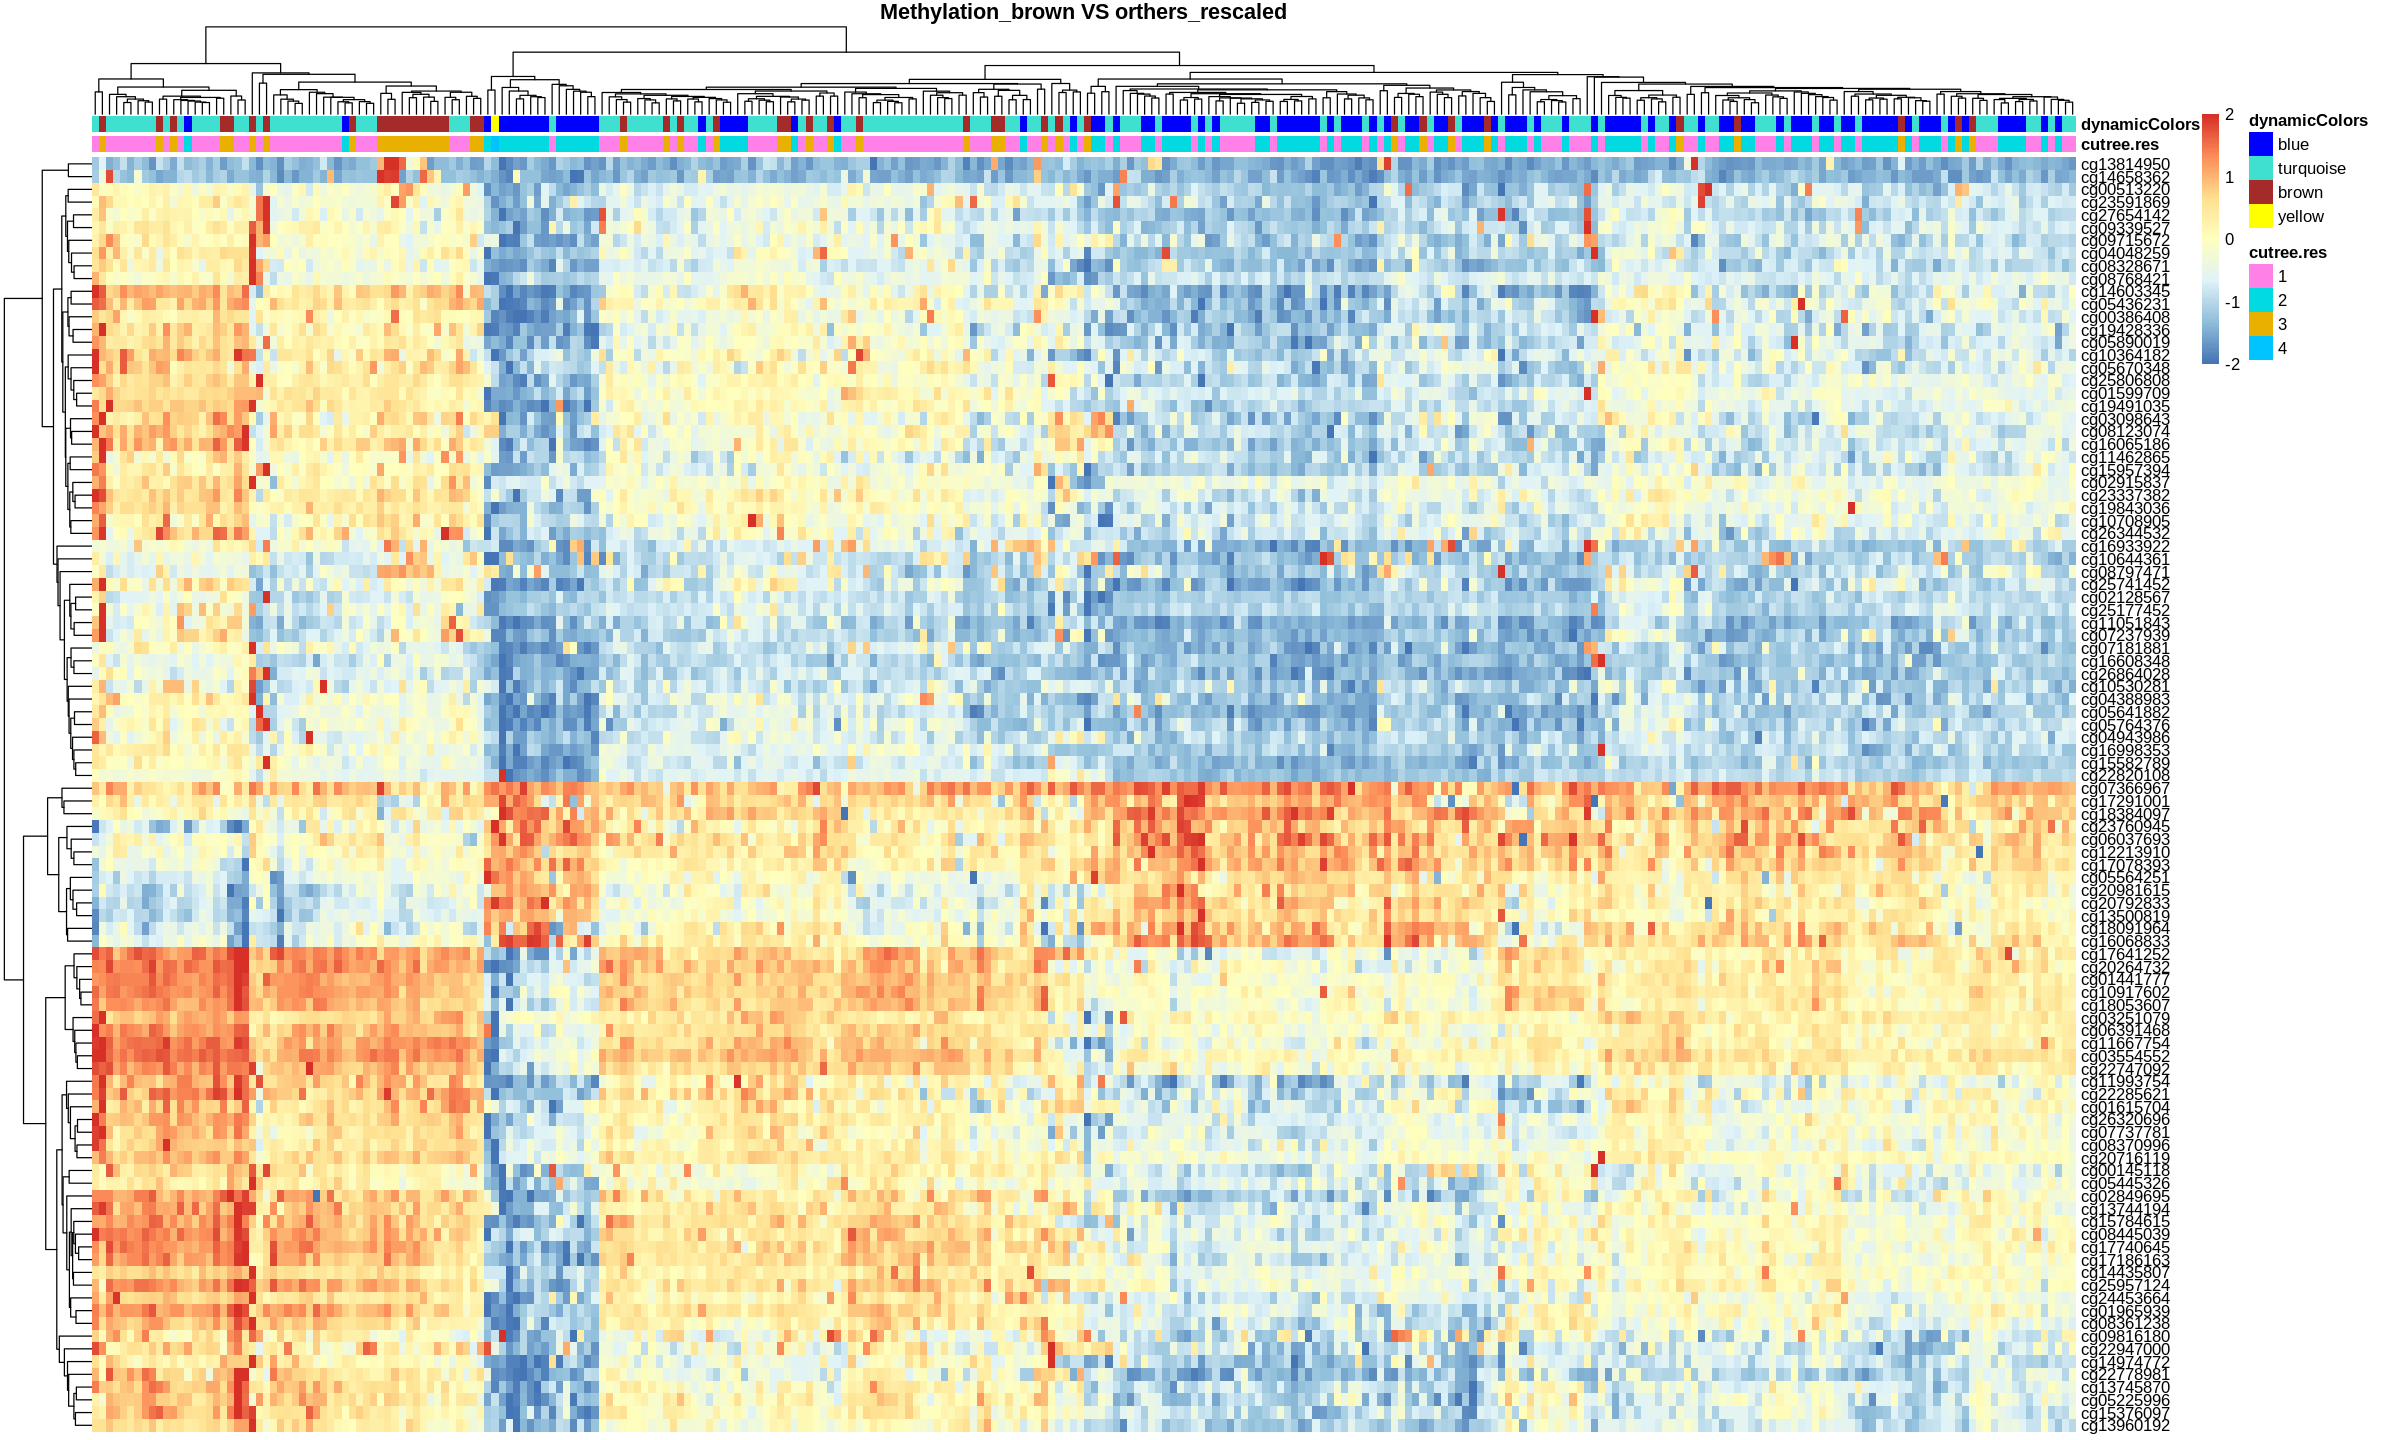

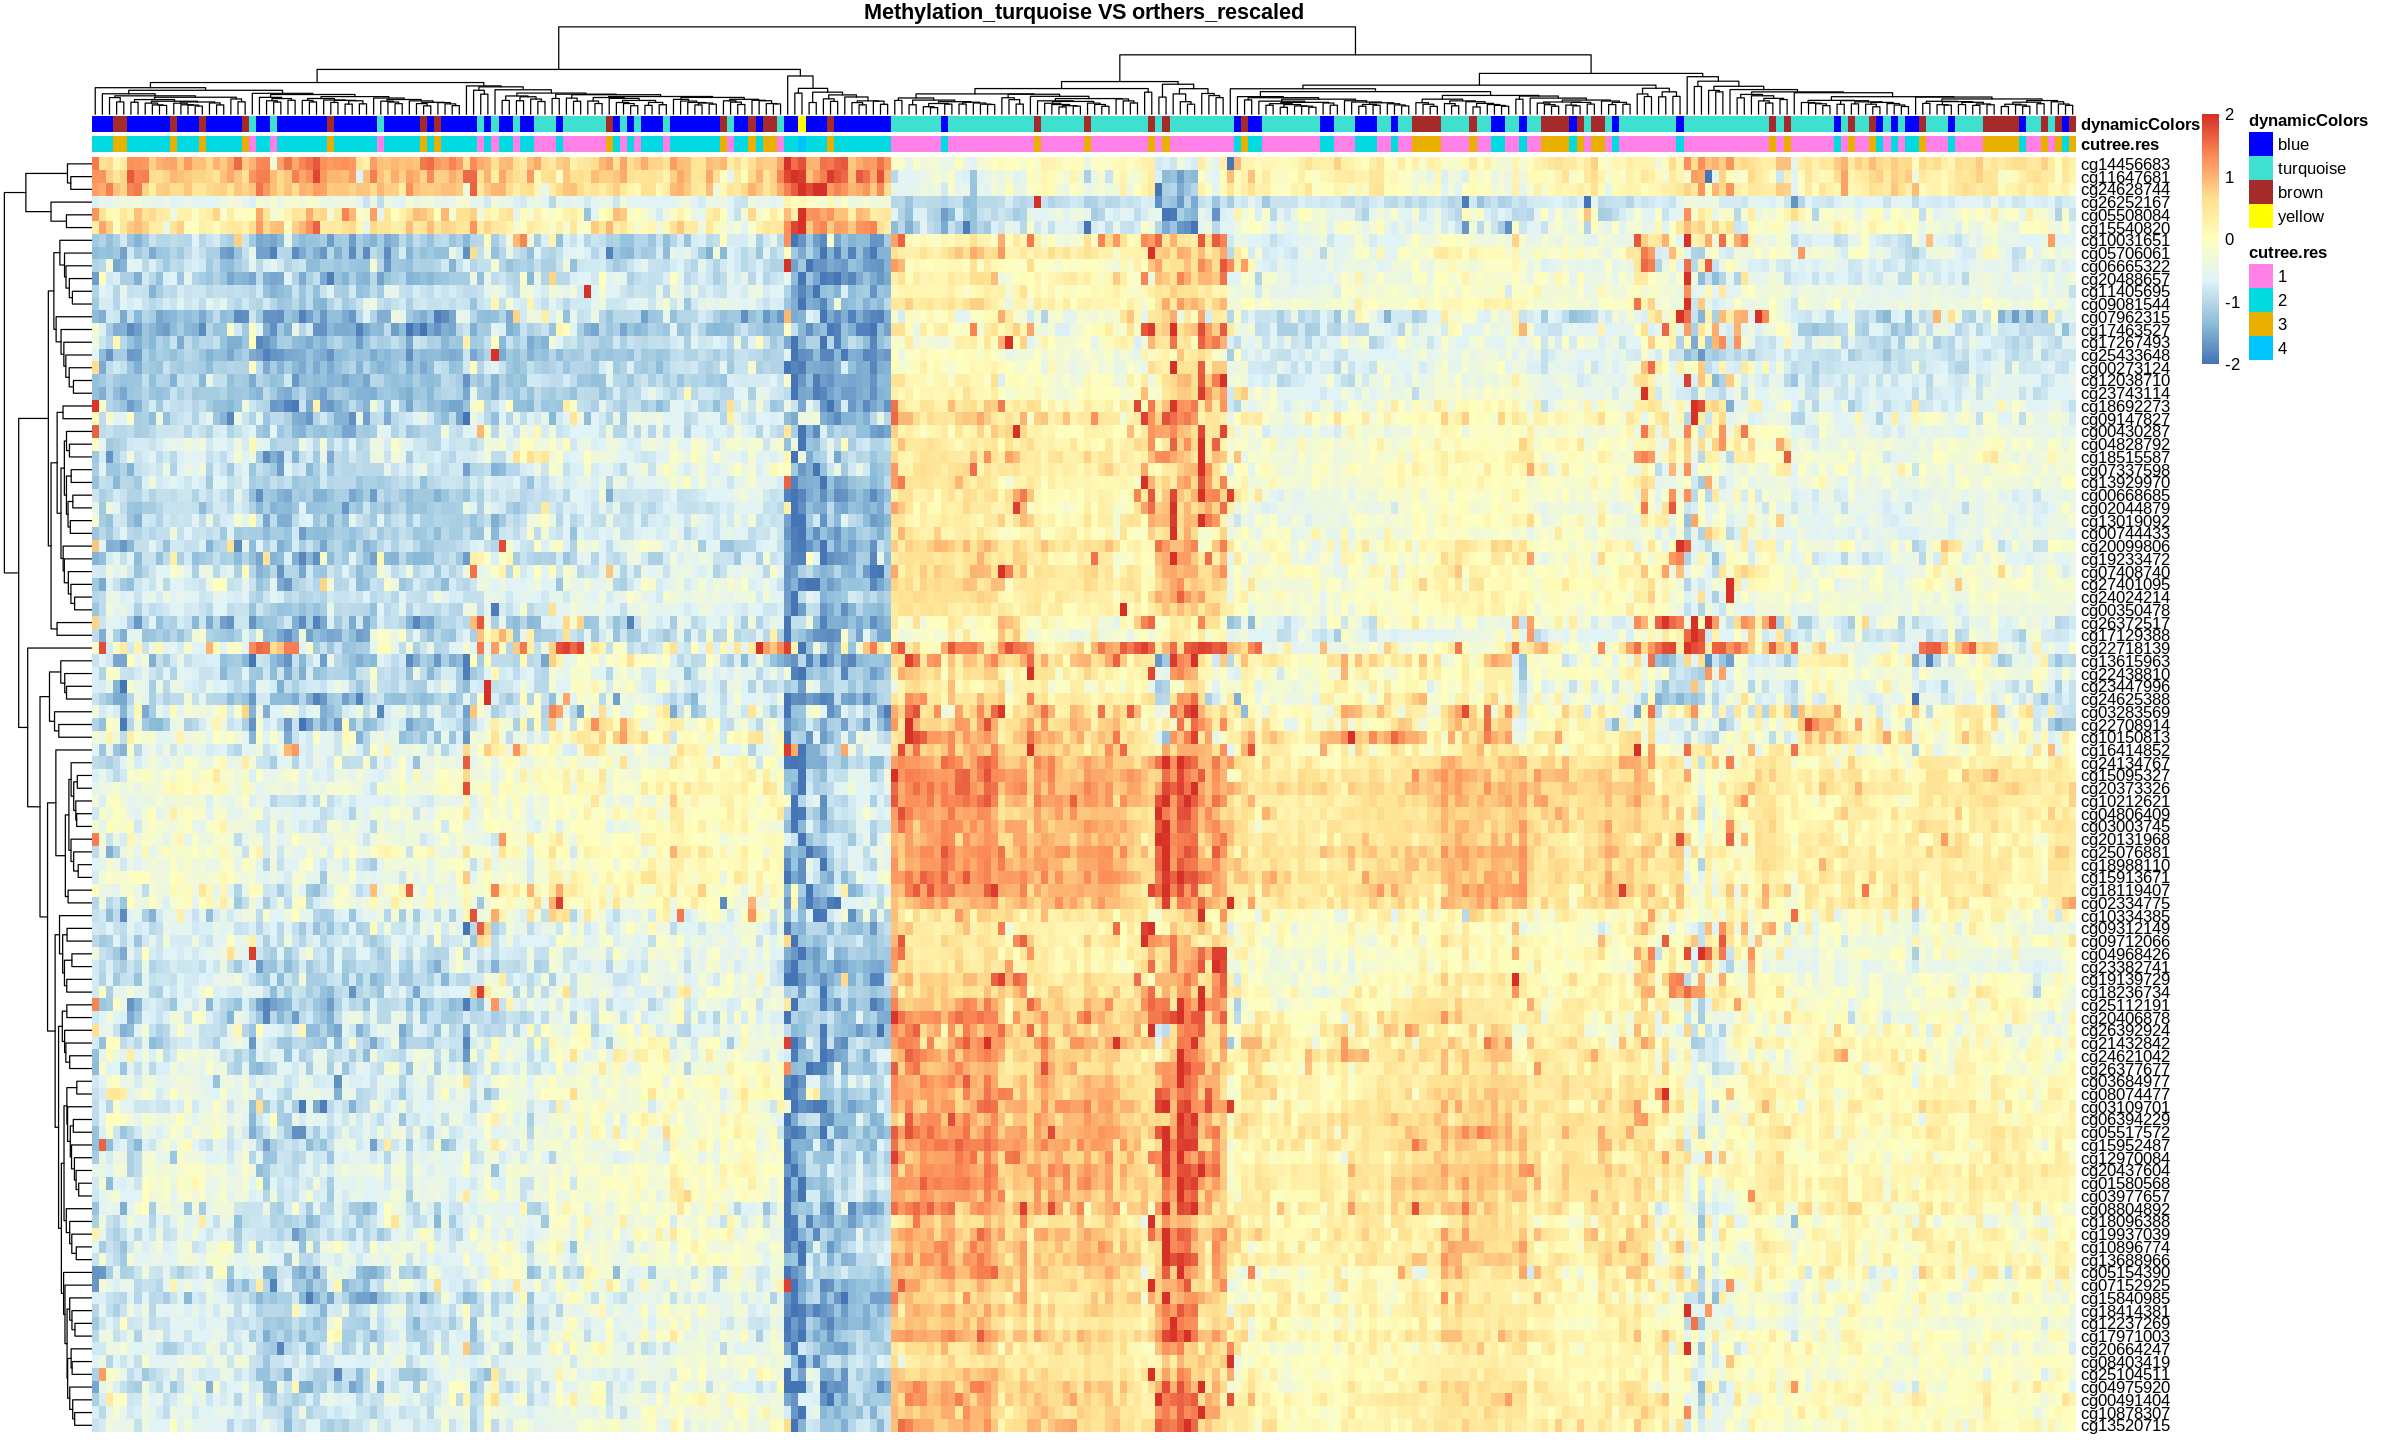

In [5]:
### 10) Ploting rescaled methylation data
library(scales)
COAD.methy.scaled <- t(apply(COAD.methy.set, 1, rescale, to=c(-2,2)))
summary(COAD.methy.scaled[5,])
options(repr.plot.width=20, repr.plot.height=12)
pheatmap::pheatmap(COAD.methy.scaled[rownames(DMPs.blue),],annotation_col = pData(COAD.methy.set)[,1:2],show_colnames = F,
                   main = "Methylation_Blue VS orthers_rescaled",annotation_colors = ann_colors)
pheatmap::pheatmap(COAD.methy.scaled[rownames(DMPs.brown),],annotation_col = pData(COAD.methy.set)[,1:2],show_colnames = F,
                   main = "Methylation_brown VS orthers_rescaled",annotation_colors = ann_colors)
pheatmap::pheatmap(COAD.methy.scaled[rownames(DMPs.turquoise),],annotation_col = pData(COAD.methy.set)[,1:2],show_colnames = F,
                   main = "Methylation_turquoise VS orthers_rescaled",annotation_colors = ann_colors)



In [ ]:
pheatmap::pheatmap(COAD.methy.scaled,annotation_col = pData(COAD.methy.set)[,1:2],show_colnames = F,
                   main = "Methylation_All_rescaled",annotation_colors = ann_colors)
